In [1]:
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from codvidutils.Autoencoder_Uncertainty_Transformation_main import Transformation_main
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import normalize
from scipy.stats import norm
from codvidutils.imageproc import map_categorical
from PIL import Image
from keras.models import load_model, Model
import pickle

Using TensorFlow backend.


In [2]:
valid_class = pd.read_csv('data/validation_set.csv', sep=' ', header=1, names=['image_path', 'class'])
values_dict = {'pneumonia': 2, 'COVID-19': 1, 'normal': 0}
valid_class['class_categorical'] = valid_class['class'].apply(map_categorical, args=(values_dict,))

In [3]:
valid_pics = []
for img in valid_class['image_path'].values:
    valid_pics.append(np.array(Image.open('data/test/' + img))[10:190, 10:190,:3])
valid_pics = np.array(valid_pics)
diseaseID_valid = np.asarray(valid_class["class_categorical"])
Y_valid = diseaseID_valid
Y_valid[Y_valid == 2] = 0

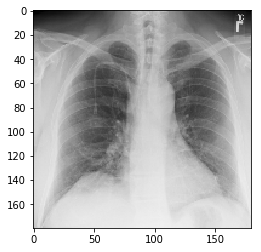

In [4]:
plt.imshow(valid_pics[0])

In [5]:
valid_pics_norm = valid_pics/255

In [6]:
best_model_path = 'hdf_files/Uncertainty_AE_Covid.hdf5'
model = load_model(best_model_path)
encoder = Model(model.layers[0].input, model.layers[9].output)
encoder_valid = encoder.predict(valid_pics_norm)
print('encoder_valid.shape', encoder_valid.shape)
encoder_valid = encoder_valid.reshape((encoder_valid.shape[0], 23*23*70))
xgb_model = pickle.load(open('log/XGBr_uncmodel_{}.pkl'.format(1), "rb"))
preds = xgb_model.predict(encoder_valid)

encoder_valid.shape (14, 23, 23, 70)


/usr/lib/python3.5/site-packages/xgboost/__init__.py:28: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [7]:
predictive_mean = np.mean(preds, axis=0)
predictive_variance = np.var(preds, axis=0)
print("Mean: {}\nStd: {}".format(predictive_mean, predictive_variance))

Mean: 0.32525211572647095
Std: 0.010297774337232113


In [8]:
mean_squared_error(Y_valid, preds)

0.23217223671380985

# The systematic error from the validation set is: 
# $$0.232$$